In [1]:
import sqlite3
import pandas as pd
import numpy as np


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

    # Define columns for processing
    time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

    # Columns for correlation matrix
    corr_columns = [
        'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 
        'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 
        'canopy_temp', 'VWC_06', 'VWC_18', 'VWC_30', 
        'daily_et', 'CWSI', 'SWSI', 'precip_irrig'
    ]

    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[corr_columns + time_columns].interpolate(method='pchip')

    return df



In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def subtract_mean(df, target_columns, keep_original_cols=True):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()
        # When keep_original_cols is True, subtract the mean from a new column
        if keep_original_cols:
            new_col_name = f"{col}_mean_subtracted"
            df[new_col_name] = df[col] - mean_value
        else:
            df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  

        # Plot the original and derived columns
        # plt.figure(figsize=(10, 6))
        # plt.plot(df[col], label=col)
        # plt.plot(df[deriv_col_name], label=deriv_col_name)
        # plt.xlabel('Time')
        # plt.ylabel('Value')
        # plt.title(f'{col} vs {deriv_col_name}')
        # plt.legend()
        # plt.show()
        

    return df, initial_values  # Return initial values as well

def scale_dataframe(df, scalers):
    """
    Scale all columns in a DataFrame using MinMaxScaler. If a scaler exists in the dictionary for a column, 
    use it; otherwise, create a new scaler, fit it, and add it to the dictionary.

    Args:
        df (pd.DataFrame): DataFrame containing the columns to be scaled.
        scalers (dict): Dictionary of pre-existing scalers.

    Returns:
        pd.DataFrame: The scaled DataFrame.
        dict: Updated dictionary of scalers.
    """
    for column in df.columns:
        if column in scalers:
            # Use the existing scaler for the column
            df[column] = scalers[column].transform(df[[column]])
        else:
            # Create a new scaler for the column, fit it, and update the dictionary
            scaler = MinMaxScaler(feature_range=(0, 1))
            df[column] = scaler.fit_transform(df[[column]])
            scalers[column] = scaler
    return df, scalers

def transform_and_scale_data(df, target_columns, scalers, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, returning the
    transformed DataFrame, updated scalers, and transformation metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        scalers (dict): Dictionary containing MinMaxScalers for each column, can be empty.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: Updated dictionary containing MinMaxScalers for each column.
        dict: A dictionary containing transformation metadata for the target columns.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    # Apply transformations directly using helper functions
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Deleting or adjusting rows as necessary (e.g., due to NaN values from differentiation)
    df_transformed = df_transformed.iloc[1:]
    
    # Subtract mean from target columns
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, keep_original_cols)
    
    # Scale all columns in df_transformed
    df_transformed, scalers = scale_dataframe(df_transformed, scalers)
    
    # print final transformed DataFrame
    print(f"Transformed DataFrame: {df_transformed.head(3)}")
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }

    return df_transformed, transformation_metadata


def reverse_transform_and_scale_data(df, transformation_metadata, target_columns):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        target_columns (list): List of target columns to be reverse transformed and scaled.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    scalers = transformation_metadata['scalers']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    keep_original_cols = transformation_metadata['keep_original_cols']

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")

    # Reverse scale the target columns
    for column in target_columns:
        if column in scalers:
            # Reshape data for inverse_transform
            scaled_data = df[[column]].values
            # Apply inverse_transform
            df[column] = scalers[column].inverse_transform(scaled_data)

    # Apply undifferencing with cumsum() and initial values if original columns were not kept
    if not keep_original_cols:
        for column in target_columns:
            # Reverse subtract mean from target columns if they were mean-adjusted
            if column in mean_values:
                df[column] = df[column] + mean_values[column]
                print(f"Reversed mean for {column}: ", df[column].head())

            # Apply cumsum() to reverse the differencing using initial values
            if column in initial_values:
                df[column] = df[column].cumsum() + initial_values[column]
                print(f"Undifferenced {column}: ", df[column].head())

    return df




# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)

# Model Definition Function for 4 Target Variables
def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True), 
        LSTM(64, return_sequences=False),  
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val


# Main Function to Execute Workflow
def run_workflow(df_processed, plot_number, time_columns, continuous_columns, target_variables,
                 input_window, forecast_horizon, stride, epochs, batch_size):
    
    print(f"df_processed shape: {df_processed.shape}")
    print(f"df_processed columns: {df_processed.columns}")
    print(f"df_processed head: {df_processed.head()}")
    
    input_data = df_processed.values
    X, y = create_sequences(input_data, df_processed[target_variables].values, input_window, forecast_horizon)    
    
    X_train, X_val, y_train, y_val = chronological_split(X, y)

    model = build_model((input_window, X.shape[2]), len(target_variables))

    # Define the checkpoint path and directory
    checkpoint_path = f"./LSTM_{plot_number}"

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=False,
                                                     monitor='val_loss',
                                                     mode='min',
                                                     save_best_only=True,
                                                     
                                                     verbose=1)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Fit model with callbacks
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, cp_callback])
    
    return checkpoint_path


# Example Usage
plot_number = 2014


# Initialize a scaler
scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]
derivative_columns = ['precip_irrig']

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 5
batch_size = 32  # Adjust based on your dataset size and memory capacity

# process data and get the scaler for unscaling the predictions
df= process_data_for_plot(plot_number) 
df_transformed, transformation_metadata = transform_and_scale_data(df, target_columns, scalers, keep_original_cols=False)

# run the workflow for training the model
checkpoint_path = run_workflow(df_transformed, plot_number, time_columns, continuous_columns, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size)


    


Transformed DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-31 02:00:00   0.597832   0.783370           0.0      0.198102   
2023-07-31 03:00:00   0.554563   0.843400           0.0      0.290707   
2023-07-31 04:00:00   0.527297   0.872121           0.0      0.234887   

                     Dp_2m_Avg  TaMax_2m  TaMin_2m  RHMax_2m  RHMin_2m  \
TIMESTAMP                                                                
2023-07-31 02:00:00   0.906476  0.598210  0.596849  0.782789  0.783764   
2023-07-31 03:00:00   0.892255  0.554489  0.553839  0.842915  0.843913   
2023-07-31 04:00:00   0.874157  0.527709  0.526359  0.871804  0.872709   

                     HeatIndex_2m_Avg  ...  daily_et      CWSI      SWSI  \
TIMESTAMP                              ...                                 
2023-07-31 02:00:00          0.687566  ...   0.22803  0.634741  0.003396   
2023-07-31 0

INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 25s 1s/step - loss: 0.0077 - val_loss: 0.0037
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.0032
Epoch 2: val_loss improved from 0.00369 to 0.00246, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 18s 1s/step - loss: 0.0032 - val_loss: 0.0025
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.0027
Epoch 3: val_loss improved from 0.00246 to 0.00232, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 15s 1s/step - loss: 0.0027 - val_loss: 0.0023
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.0027
Epoch 4: val_loss improved from 0.00232 to 0.00226, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 6s 469ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.0027
Epoch 5: val_loss improved from 0.00226 to 0.00225, saving model to .\LSTM_2014
INFO:tensorflow:Assets written to: .\LSTM_2014\assets


INFO:tensorflow:Assets written to: .\LSTM_2014\assets


14/14 [==============================] - 6s 469ms/step - loss: 0.0027 - val_loss: 0.0023


Processing plot number 2015
Transformed DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-21 01:00:00   0.335051   0.914595      0.001981      0.167937   
2023-07-21 02:00:00   0.311742   0.906904      0.000000      0.162826   
2023-07-21 03:00:00   0.296860   0.959723      0.000000      0.053708   

                     Dp_2m_Avg  TaMax_2m  TaMin_2m  RHMax_2m  RHMin_2m  \
TIMESTAMP                                                                
2023-07-21 01:00:00   0.613860  0.335240  0.333918  0.915156  0.913727   
2023-07-21 02:00:00   0.572818  0.312080  0.310381  0.907469  0.906329   
2023-07-21 03:00:00   0.587869  0.297037  0.295699  0.959818  0.959701   

                     HeatIndex_2m_Avg  ...  daily_et      CWSI      SWSI  \
TIMESTAMP                              ...                                 
2023-07-21 01:00:00          0.359957  ...  0.104814  0.2036

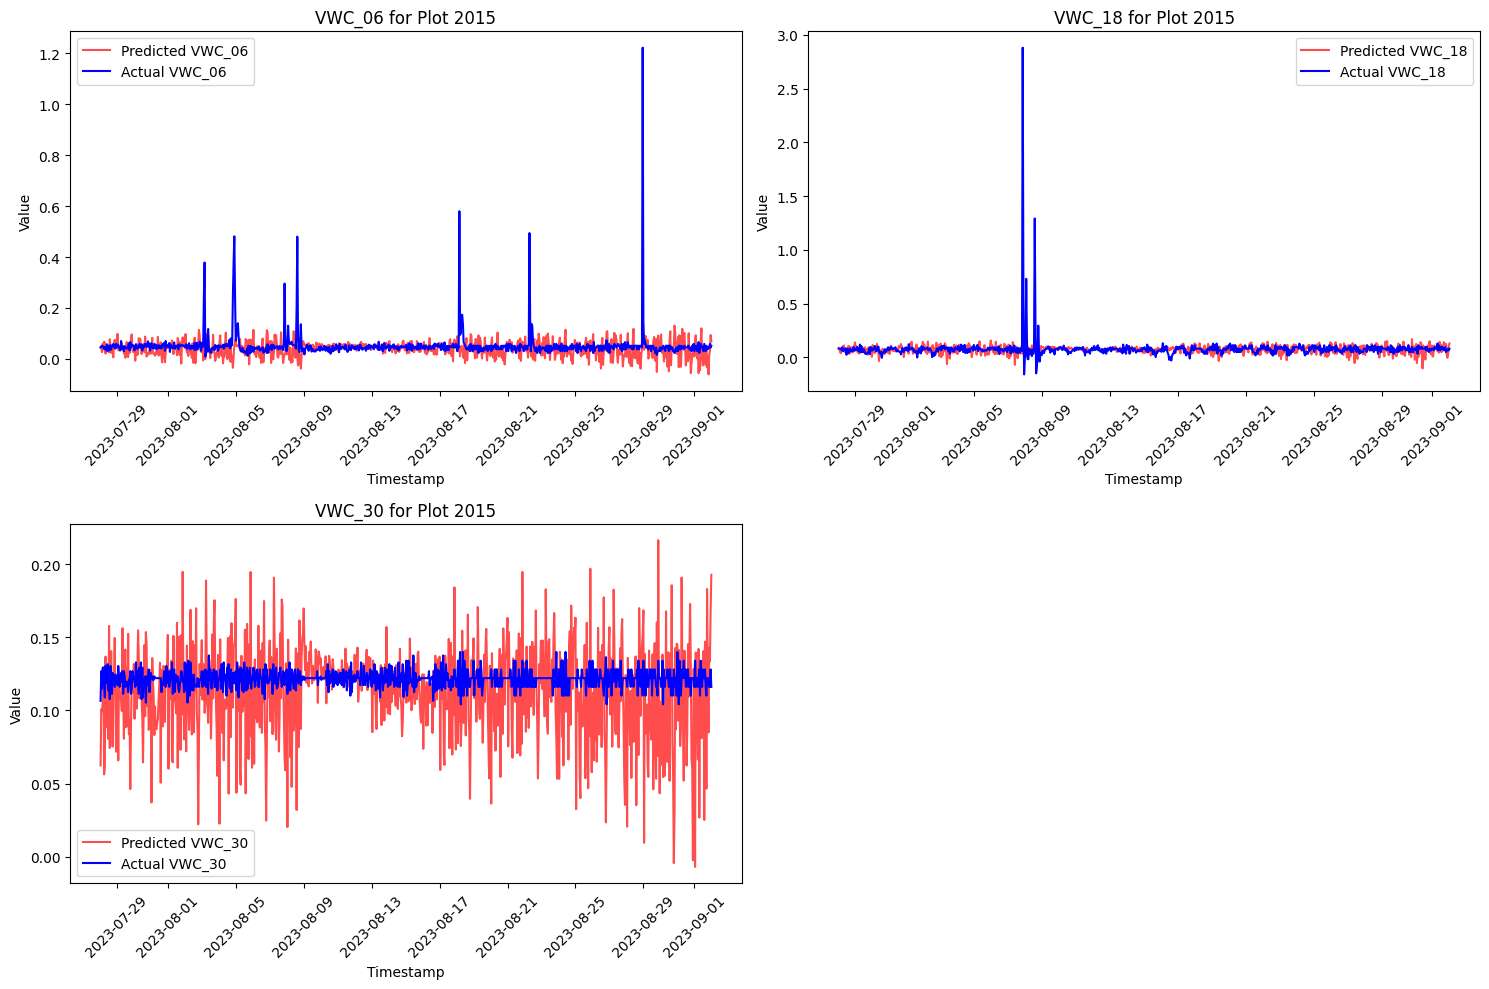

Shape of input DataFrame: (864, 3)
Reversed mean for VWC_06:  TIMESTAMP
2023-07-28 01:00:00   -0.030107
2023-07-28 02:00:00   -0.012865
2023-07-28 03:00:00   -0.087150
2023-07-28 04:00:00    0.029615
2023-07-28 05:00:00   -0.049537
Name: VWC_06, dtype: float32
Undifferenced VWC_06:  TIMESTAMP
2023-07-28 01:00:00    21.099892
2023-07-28 02:00:00    21.087027
2023-07-28 03:00:00    20.999876
2023-07-28 04:00:00    21.029491
2023-07-28 05:00:00    20.979956
Name: VWC_06, dtype: float32
Reversed mean for VWC_18:  TIMESTAMP
2023-07-28 01:00:00    0.014644
2023-07-28 02:00:00   -0.008069
2023-07-28 03:00:00   -0.044706
2023-07-28 04:00:00   -0.064482
2023-07-28 05:00:00    0.015468
Name: VWC_18, dtype: float32
Undifferenced VWC_18:  TIMESTAMP
2023-07-28 01:00:00    20.414644
2023-07-28 02:00:00    20.406576
2023-07-28 03:00:00    20.361870
2023-07-28 04:00:00    20.297386
2023-07-28 05:00:00    20.312855
Name: VWC_18, dtype: float32
Reversed mean for VWC_30:  TIMESTAMP
2023-07-28 01:00:00   

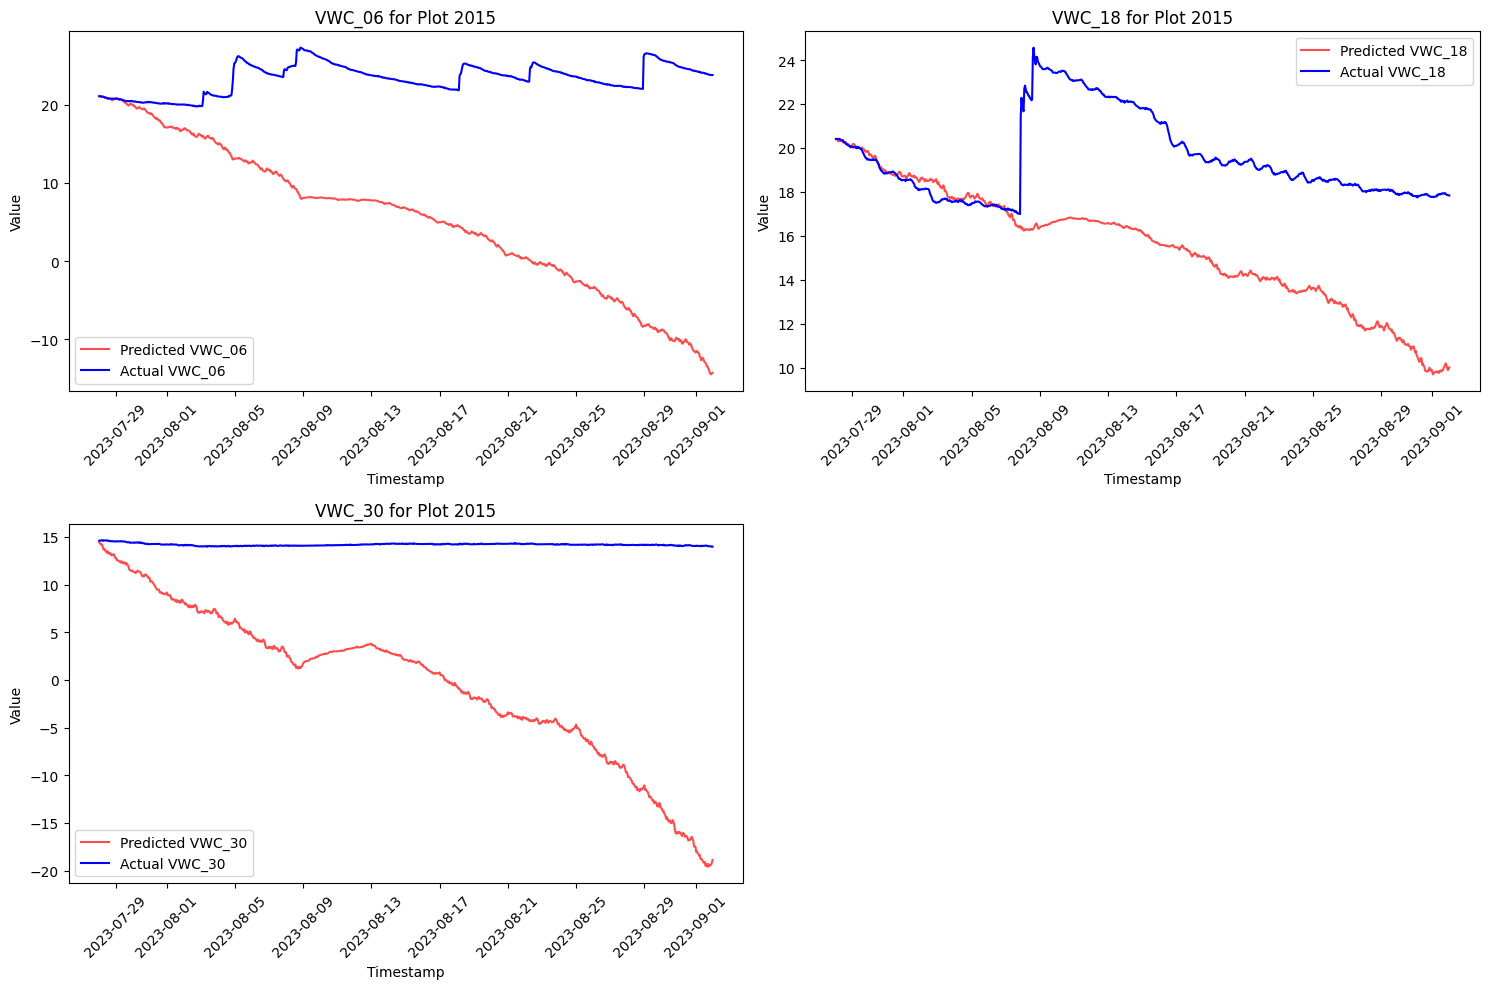

Processing plot number 2001
Transformed DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-20 02:00:00   0.495753   0.900140           0.0      0.100644   
2023-07-20 03:00:00   0.453217   0.955725           0.0      0.046077   
2023-07-20 04:00:00   0.457106   0.962678           0.0      0.043147   

                     Dp_2m_Avg  TaMax_2m  TaMin_2m  RHMax_2m  RHMin_2m  \
TIMESTAMP                                                                
2023-07-20 02:00:00   0.847972  0.495803  0.494622  0.899611  0.900369   
2023-07-20 03:00:00   0.824416  0.453510  0.452199  0.955927  0.955690   
2023-07-20 04:00:00   0.835549  0.457506  0.455775  0.962589  0.962710   

                     HeatIndex_2m_Avg  ...  daily_et      CWSI      SWSI  \
TIMESTAMP                              ...                                 
2023-07-20 02:00:00          0.533236  ...  0.001036  0.1044

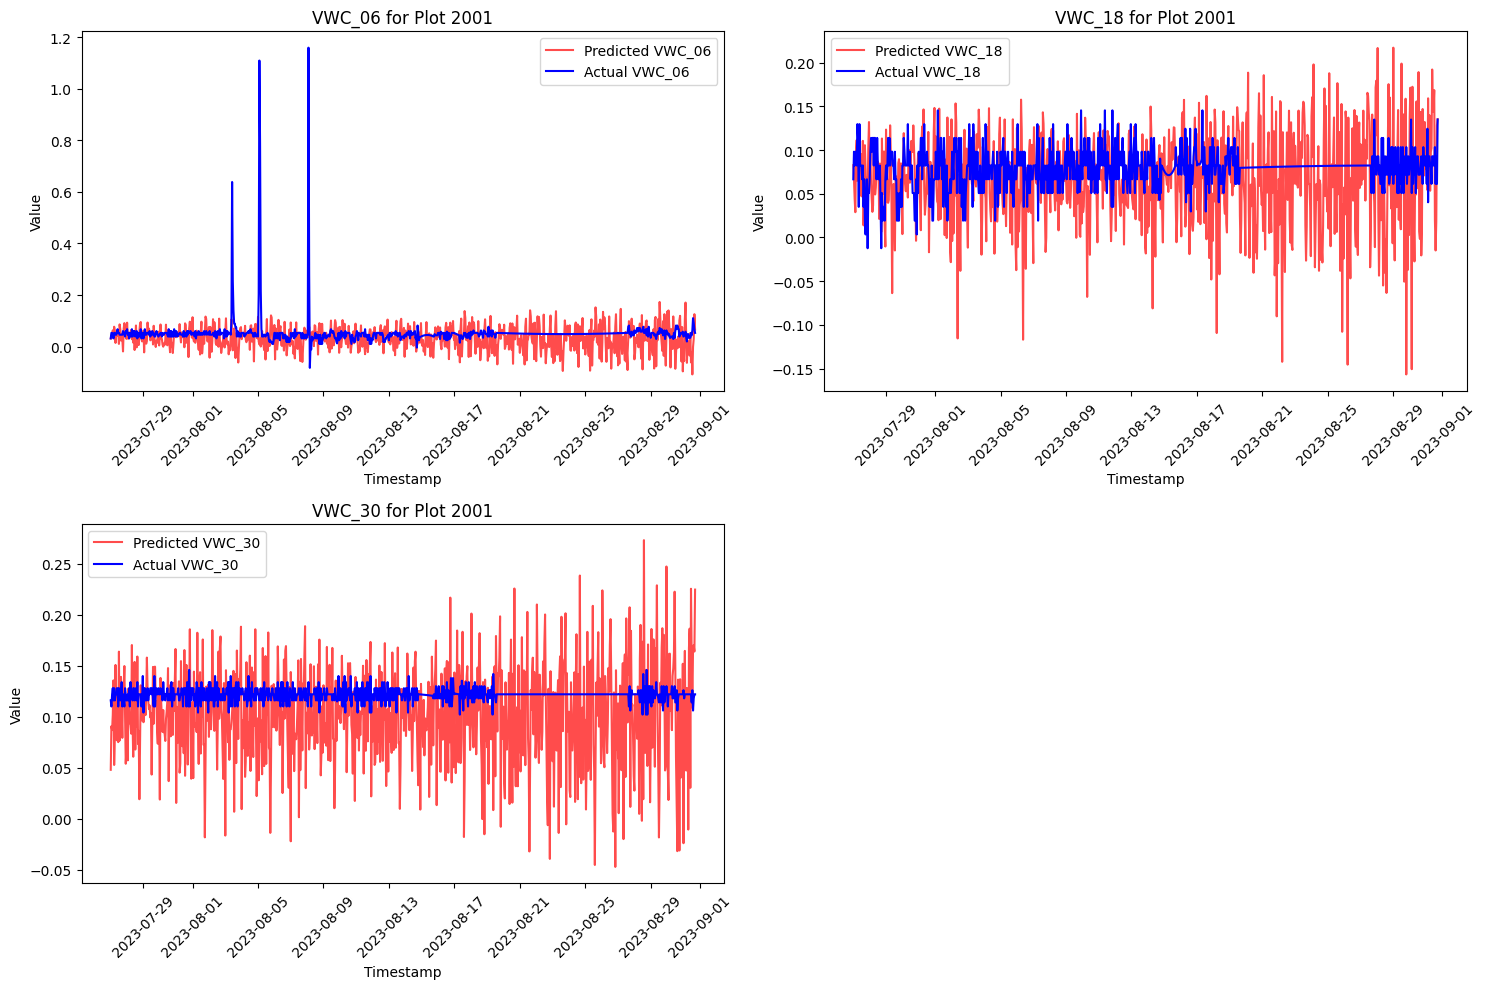

Shape of input DataFrame: (864, 3)
Reversed mean for VWC_06:  TIMESTAMP
2023-07-27 00:00:00   -0.070261
2023-07-27 01:00:00   -0.020635
2023-07-27 02:00:00   -0.052879
2023-07-27 03:00:00    0.041153
2023-07-27 04:00:00   -0.062335
Name: VWC_06, dtype: float32
Undifferenced VWC_06:  TIMESTAMP
2023-07-27 00:00:00    21.059738
2023-07-27 01:00:00    21.039103
2023-07-27 02:00:00    20.986225
2023-07-27 03:00:00    21.027378
2023-07-27 04:00:00    20.965042
Name: VWC_06, dtype: float32
Reversed mean for VWC_18:  TIMESTAMP
2023-07-27 00:00:00    0.006204
2023-07-27 01:00:00   -0.019793
2023-07-27 02:00:00   -0.055356
2023-07-27 03:00:00   -0.079133
2023-07-27 04:00:00    0.032137
Name: VWC_18, dtype: float32
Undifferenced VWC_18:  TIMESTAMP
2023-07-27 00:00:00    20.406204
2023-07-27 01:00:00    20.386410
2023-07-27 02:00:00    20.331055
2023-07-27 03:00:00    20.251921
2023-07-27 04:00:00    20.284058
Name: VWC_18, dtype: float32
Reversed mean for VWC_30:  TIMESTAMP
2023-07-27 00:00:00   

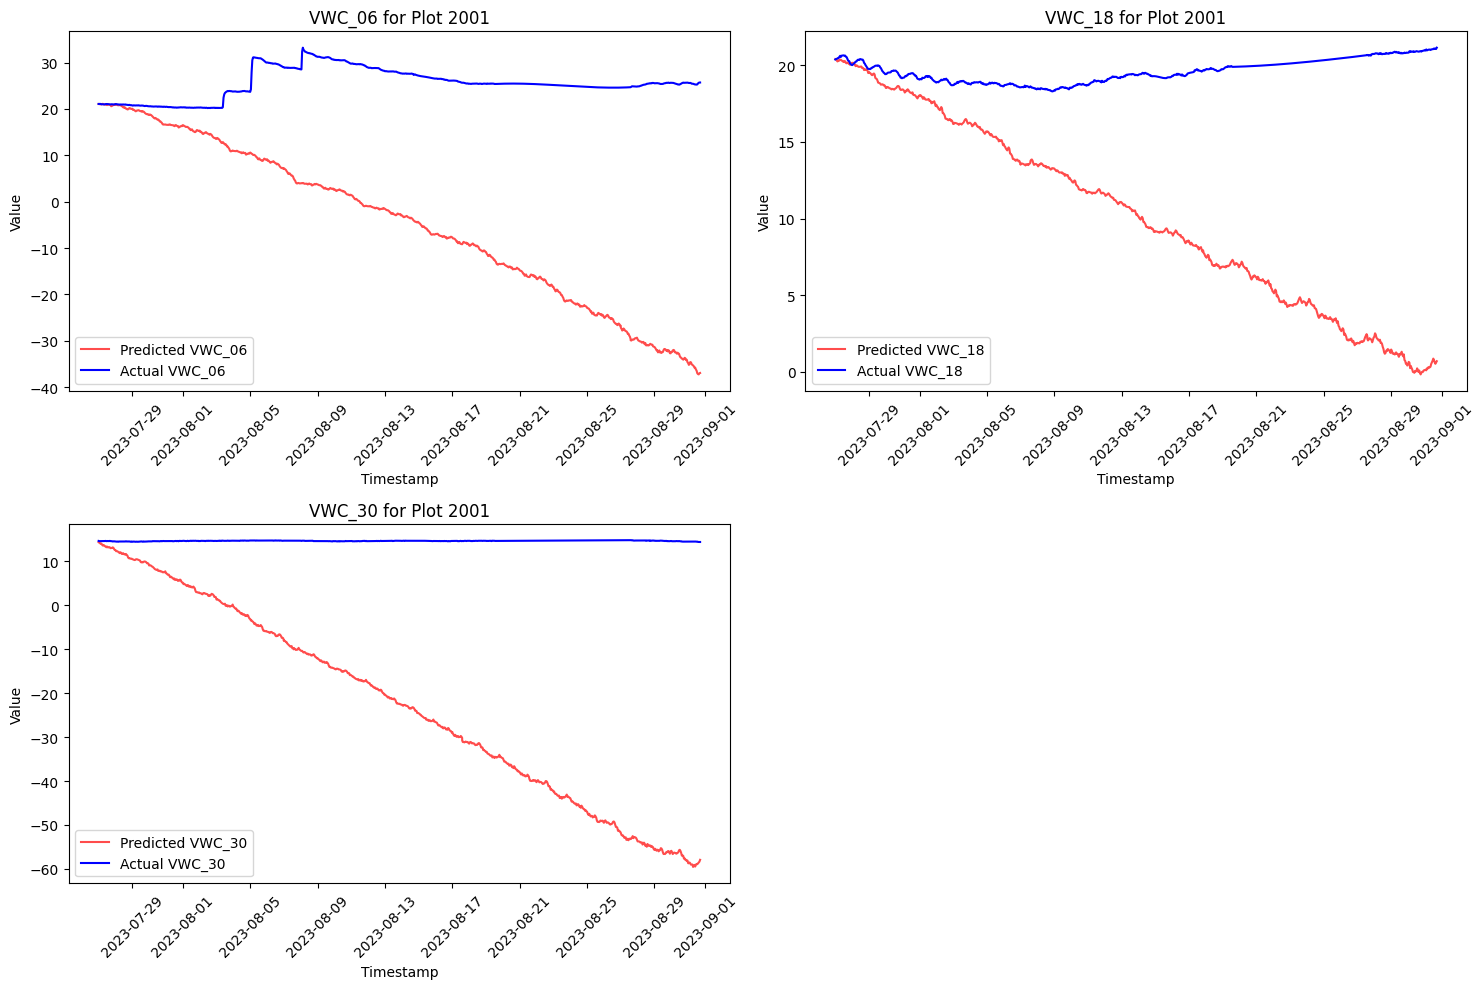

Processing plot number 2013
Transformed DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-25 15:00:00   0.605140   0.678852      0.605225      0.234528   
2023-07-25 16:00:00   0.631936   0.667212      0.780010      0.164099   
2023-07-25 17:00:00   0.707120   0.562372      0.931031      0.312860   

                     Dp_2m_Avg  TaMax_2m  TaMin_2m  RHMax_2m  RHMin_2m  \
TIMESTAMP                                                                
2023-07-25 15:00:00   0.821151  0.605464  0.603844  0.692264  0.667451   
2023-07-25 16:00:00   0.849174  0.632542  0.630266  0.684583  0.652839   
2023-07-25 17:00:00   0.847489  0.707348  0.705762  0.576561  0.549546   

                     HeatIndex_2m_Avg  ...  daily_et      CWSI      SWSI  \
TIMESTAMP                              ...                                 
2023-07-25 15:00:00          0.688375  ...  0.219287  0.4811

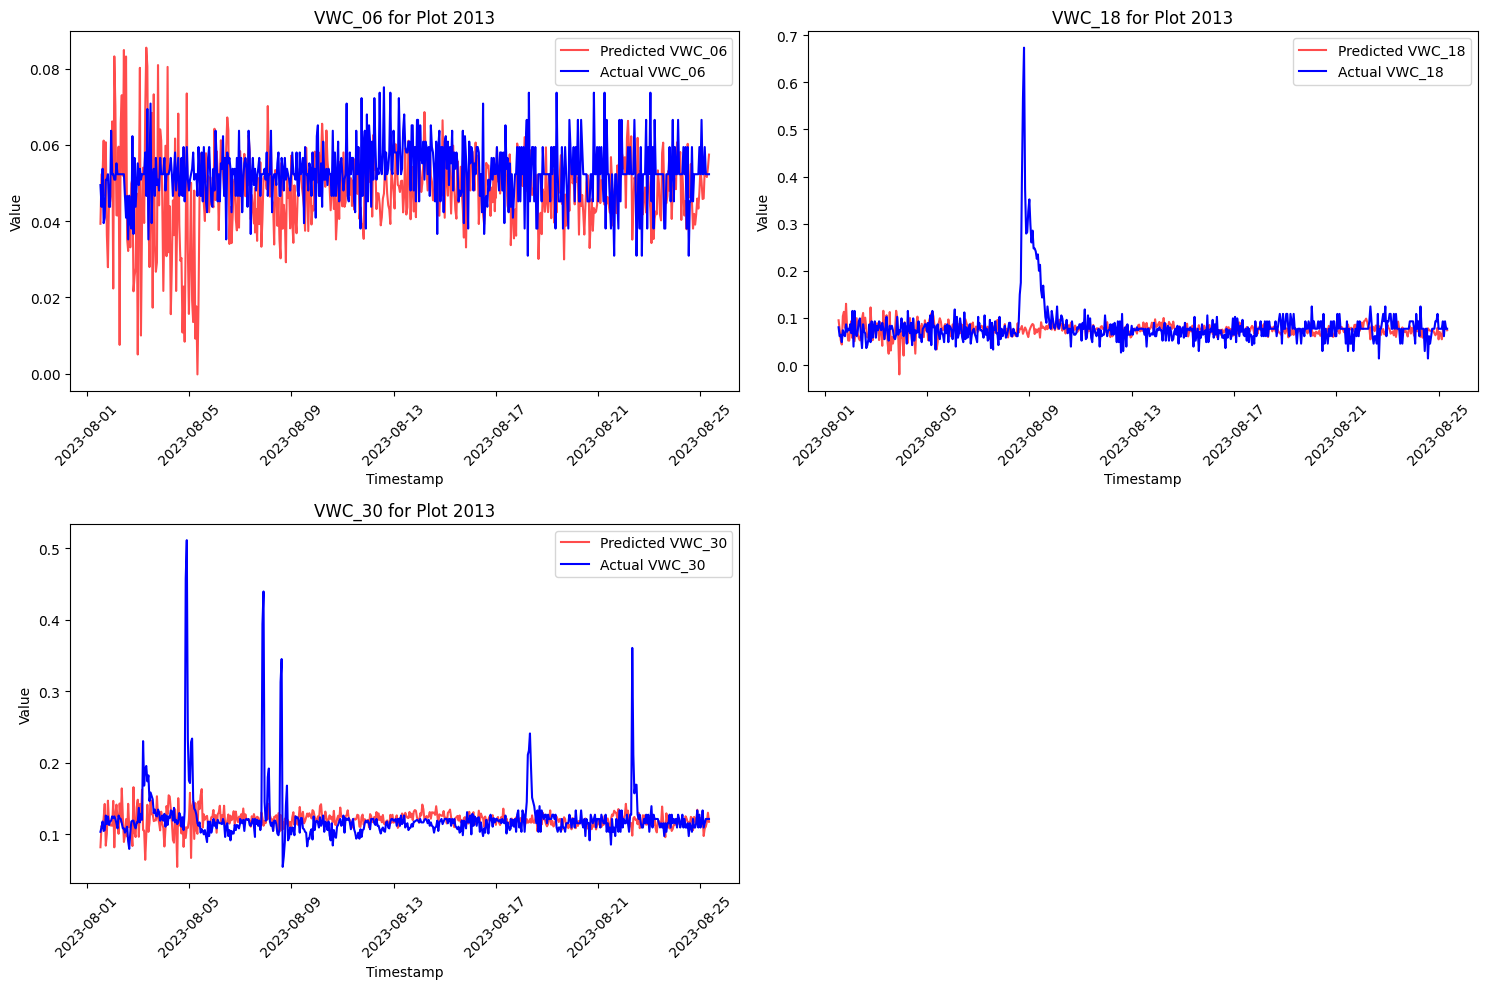

Shape of input DataFrame: (576, 3)
Reversed mean for VWC_06:  TIMESTAMP
2023-08-01 13:00:00   -0.042201
2023-08-01 14:00:00    0.003249
2023-08-01 15:00:00    0.004764
2023-08-01 16:00:00    0.034343
2023-08-01 17:00:00   -0.015900
Name: VWC_06, dtype: float32
Undifferenced VWC_06:  TIMESTAMP
2023-08-01 13:00:00    21.087797
2023-08-01 14:00:00    21.091047
2023-08-01 15:00:00    21.095810
2023-08-01 16:00:00    21.130154
2023-08-01 17:00:00    21.114254
Name: VWC_06, dtype: float32
Reversed mean for VWC_18:  TIMESTAMP
2023-08-01 13:00:00    0.025755
2023-08-01 14:00:00   -0.004405
2023-08-01 15:00:00   -0.040793
2023-08-01 16:00:00   -0.055706
2023-08-01 17:00:00    0.039797
Name: VWC_18, dtype: float32
Undifferenced VWC_18:  TIMESTAMP
2023-08-01 13:00:00    20.425755
2023-08-01 14:00:00    20.421350
2023-08-01 15:00:00    20.380556
2023-08-01 16:00:00    20.324850
2023-08-01 17:00:00    20.364649
Name: VWC_18, dtype: float32
Reversed mean for VWC_30:  TIMESTAMP
2023-08-01 13:00:00   

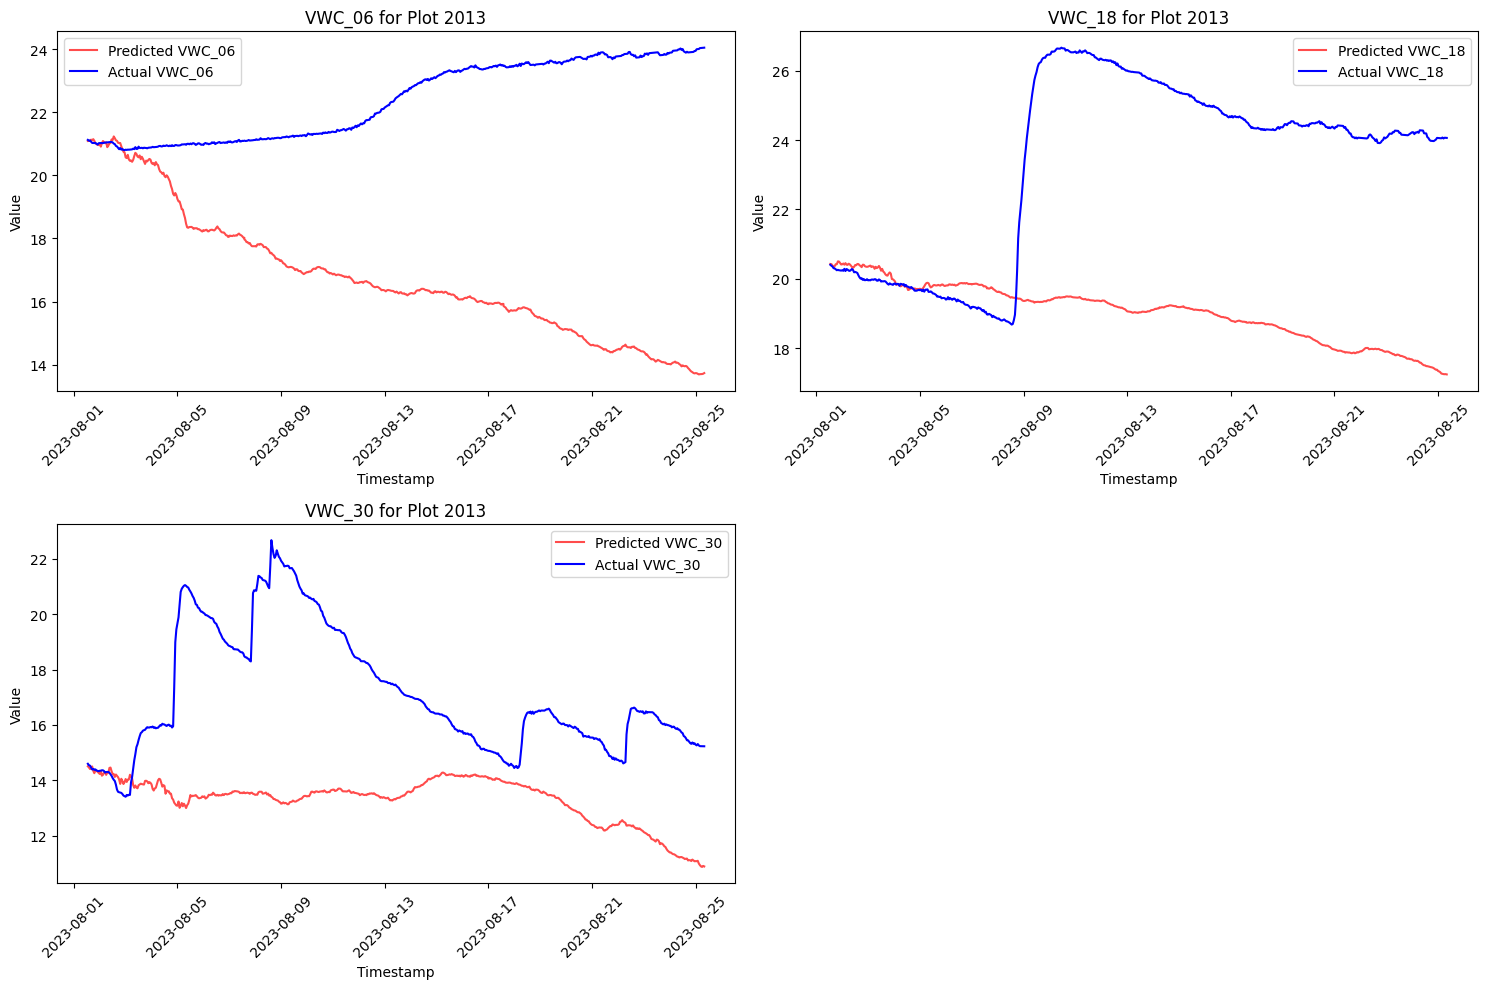

Processing plot number 2007
Transformed DataFrame:                      Ta_2m_Avg  RH_2m_Avg  Solar_2m_Avg  WndAveSpd_3m  \
TIMESTAMP                                                               
2023-07-20 02:00:00   0.495753   0.900140           0.0      0.100644   
2023-07-20 03:00:00   0.453217   0.955725           0.0      0.046077   
2023-07-20 04:00:00   0.457106   0.962678           0.0      0.043147   

                     Dp_2m_Avg  TaMax_2m  TaMin_2m  RHMax_2m  RHMin_2m  \
TIMESTAMP                                                                
2023-07-20 02:00:00   0.847972  0.495803  0.494622  0.899611  0.900369   
2023-07-20 03:00:00   0.824416  0.453510  0.452199  0.955927  0.955690   
2023-07-20 04:00:00   0.835549  0.457506  0.455775  0.962589  0.962710   

                     HeatIndex_2m_Avg  ...  daily_et      CWSI      SWSI  \
TIMESTAMP                              ...                                 
2023-07-20 02:00:00          0.533236  ...  0.001036  0.0947

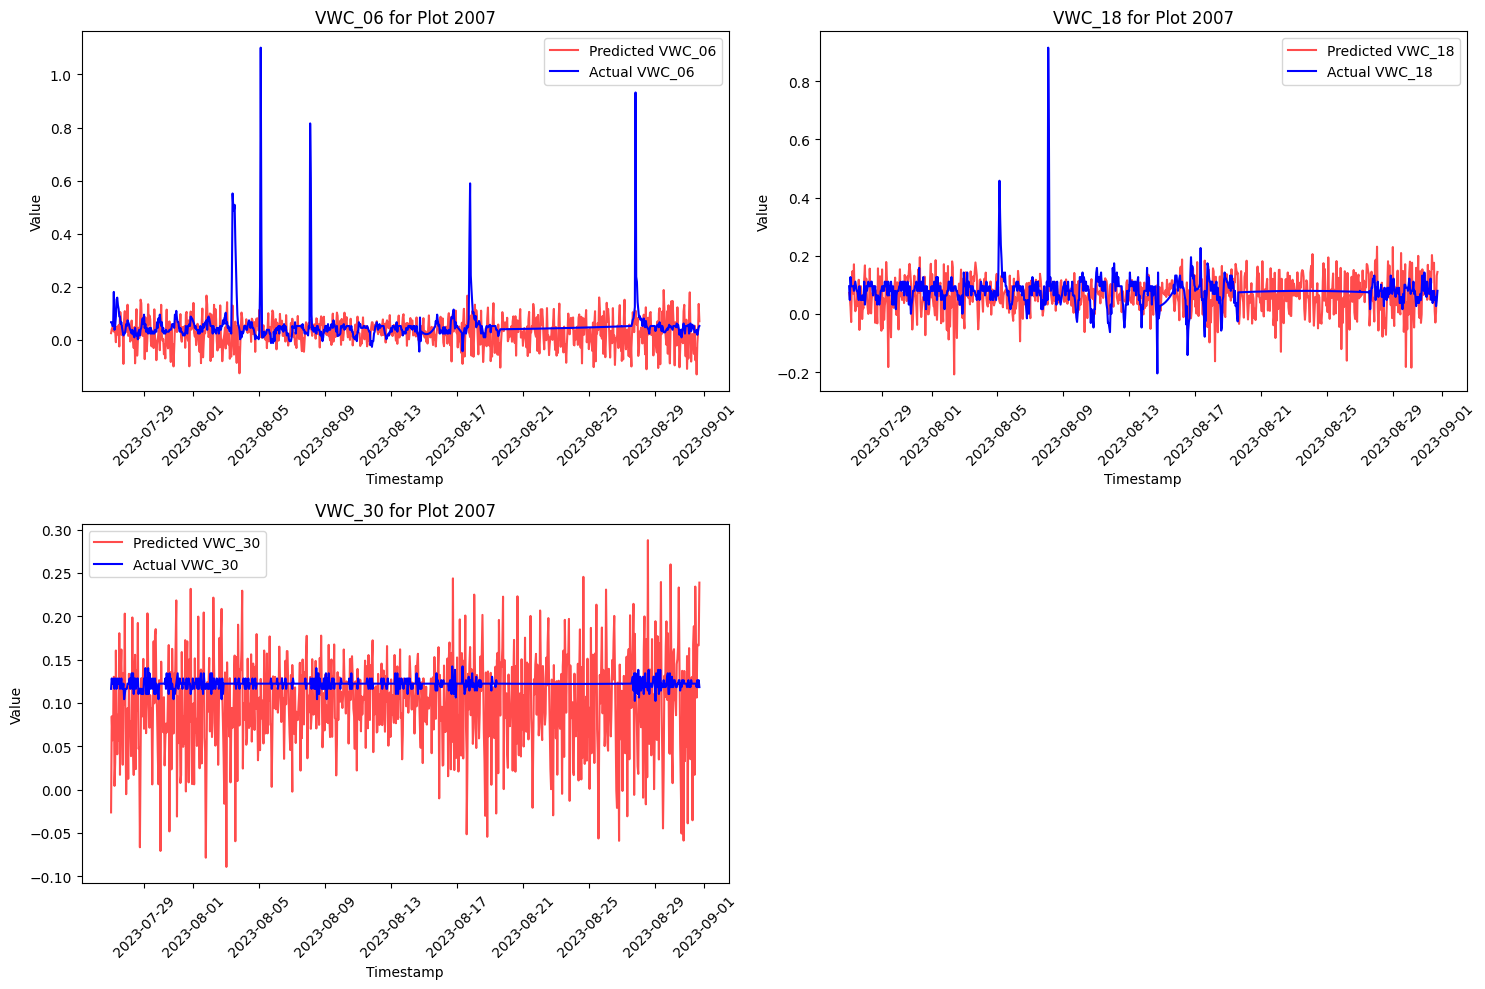

Shape of input DataFrame: (864, 3)
Reversed mean for VWC_06:  TIMESTAMP
2023-07-27 00:00:00   -0.090646
2023-07-27 01:00:00   -0.038717
2023-07-27 02:00:00   -0.014747
2023-07-27 03:00:00    0.001327
2023-07-27 04:00:00   -0.068852
Name: VWC_06, dtype: float32
Undifferenced VWC_06:  TIMESTAMP
2023-07-27 00:00:00    21.039352
2023-07-27 01:00:00    21.000635
2023-07-27 02:00:00    20.985888
2023-07-27 03:00:00    20.987215
2023-07-27 04:00:00    20.918364
Name: VWC_06, dtype: float32
Reversed mean for VWC_18:  TIMESTAMP
2023-07-27 00:00:00   -0.009852
2023-07-27 01:00:00   -0.033616
2023-07-27 02:00:00   -0.087402
2023-07-27 03:00:00   -0.169175
2023-07-27 04:00:00    0.062616
Name: VWC_18, dtype: float32
Undifferenced VWC_18:  TIMESTAMP
2023-07-27 00:00:00    20.390148
2023-07-27 01:00:00    20.356531
2023-07-27 02:00:00    20.269131
2023-07-27 03:00:00    20.099955
2023-07-27 04:00:00    20.162571
Name: VWC_18, dtype: float32
Reversed mean for VWC_30:  TIMESTAMP
2023-07-27 00:00:00   

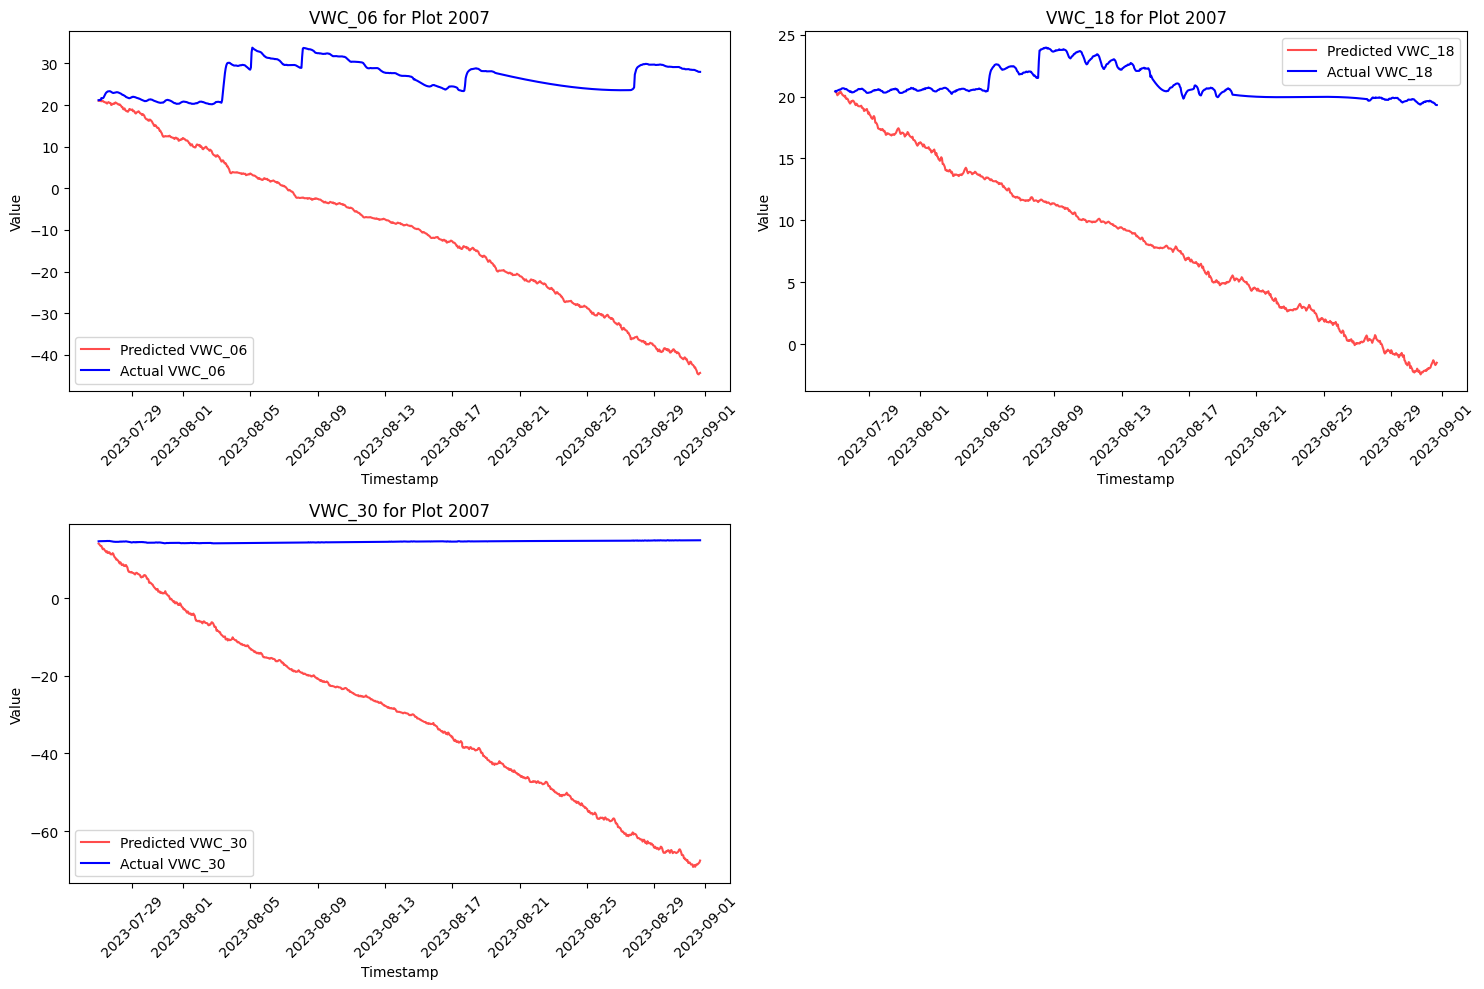

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
    num_plots = len(target_columns)
    num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
    for i, column in enumerate(target_columns):
        plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
        plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
        plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
        plt.legend()
        plt.title(f'{column} for Plot {plot_number}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_with_sliding_window(model, df, transformation_metadata, time_columns, continuous_columns, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # first iteration flag
    first_iter = True

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))

        

        pred = model.predict(sequence)

        
        if first_iter:
            print(f"Sequence shape: {sequence.shape}")
            # To print the top 3 lines, slice the second dimension (sequence length)
            print("Sequence (top 3 lines):")
            print(sequence[0, :3, :])  # Access the first element of the first dimension, then slice
            print(f"Predicted shape: {pred.shape}")
            # Similarly, for the predictions, slice the second dimension
            print("Predicted (top 3 lines):")
            print(pred[0, :3, :])  # Access the first element of the first dimension, then slice
        
            first_iter = False


        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)

    # Apply reverse transformation and scaling to both predictions and actuals

    # Plot the predictions and actuals before reverse transformation and scaling
    print("Plotting predictions and actuals before reverse transformation and scaling")
    print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))

    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, transformation_metadata, target_columns)
    actuals_df = reverse_transform_and_scale_data(actuals_df, transformation_metadata, target_columns)

    # Example usage
    print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))
    print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    return predictions_df, actuals_df, timestamps

# Array of plot numbers
plot_numbers = [2015, 2001, 2013, 2007]
#plot_numbers = [2015]

# initialize predictions_df and actuals_df and timestamps as empty dataframes
predictions_df = pd.DataFrame()
actuals_df = pd.DataFrame()
timestamps = pd.Series()

# initialize scalers from transformation_metadata
scalers = transformation_metadata['scalers']
keep_original_cols = transformation_metadata['keep_original_cols'] 

# Loop through plot numbers
for plot_number in plot_numbers:
    print(f"Processing plot number {plot_number}")
    
    model = tf.keras.models.load_model(checkpoint_path)
    

    df_plot = process_data_for_plot(plot_number)
    
    #drop VWC_40 column if it exists
    if 'VWC_42' in df_plot.columns:
        df_plot = df_plot.drop(columns=['VWC_42'])

    df_plot, _ = transform_and_scale_data(df_plot, target_columns, scalers, keep_original_cols)
    

    
    predictions_df, actuals_df, timestamps = predict_with_sliding_window(model, df_plot, transformation_metadata, time_columns=time_columns, continuous_columns=continuous_columns, target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=plot_number)
